# Importing Necessary Libraries

``` This notebook demonstrates a comprehensive approach to predicting customer churn using machine learning. It includes data preprocessing, exploratory data analysis, feature engineering, model training, and evaluation.```

In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
import warnings
import joblib

In [89]:
# pip install xgboost

# Step 1: Load the Dataset

In [90]:
data = pd.read_excel(r"D:\GitHub\Telco-Churn-Predictor\data\Telco_customer_churn.xlsx")
df = data.copy()

`Overview of the Data`

In [91]:
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

# Step 2: Exploratory Data Analysis (EDA)

```Convert TotalCharges to numeric and handle missing values```

In [93]:
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')
df['Total Charges'] = df['Total Charges'].astype(float)
df['Total Charges'].fillna(df['Total Charges'].median(), inplace=True)

In [94]:
df['Total Charges'].dtype

dtype('float64')

In [95]:
df.isnull().sum()

CustomerID              0
Count                   0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges           0
Churn Label             0
Churn Value             0
Churn Score             0
CLTV                    0
Churn Reason         5174
dtype: int64

``Visualize Churn Reasons``

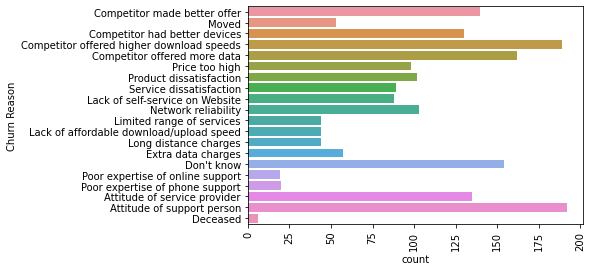

In [96]:
sns.countplot(y=df['Churn Reason'])
plt.xticks(rotation=90)
plt.show()

``Analyze Tenure Distribution by Churn Label``

<AxesSubplot:xlabel='Tenure Months', ylabel='Count'>

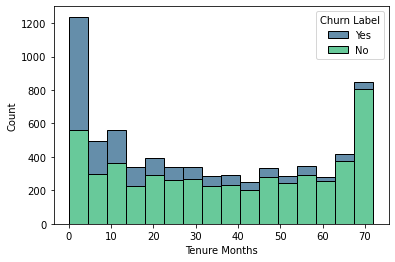

In [97]:
sns.histplot(data=df, x="Tenure Months", hue="Churn Label", multiple="stack", palette="viridis")

``Analyze Tenure Distribution by Churn Label``

<AxesSubplot:xlabel='Contract', ylabel='Count'>

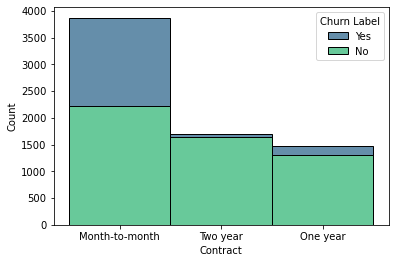

In [98]:
sns.histplot(data=df, x="Contract", hue="Churn Label", multiple="stack", palette="viridis")

<AxesSubplot:xlabel='Internet Service', ylabel='count'>

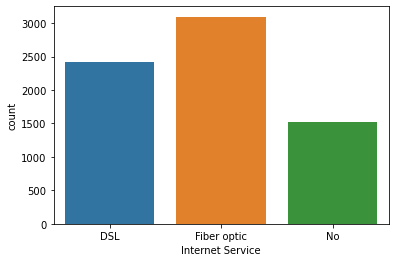

In [99]:
sns.countplot(x=df['Internet Service'])

<AxesSubplot:xlabel='Internet Service', ylabel='Count'>

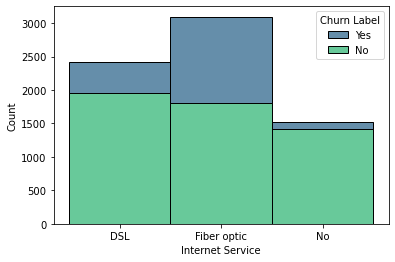

In [100]:
sns.histplot(data=df, x="Internet Service", hue="Churn Label", multiple="stack", palette="viridis")

In [101]:
df['Churn Value'].value_counts()

0    5174
1    1869
Name: Churn Value, dtype: int64

# Step 3: Feature Engineering

``Drop Irrelevant Columns``

In [102]:
df = df.drop(['Country','State','Count','Zip Code','Churn Reason','City','Churn Score','Churn Value','CLTV','CustomerID','Lat Long',
                  'Latitude','Longitude'], axis=1)

In [103]:
df.shape

(7043, 20)

In [104]:
y = df['Churn Label']

``Encode Target Variable``

In [105]:
y.replace(to_replace='Yes', value=1, inplace=True)
y.replace(to_replace='No',  value=0, inplace=True)

In [106]:
y

0       1
1       1
2       1
3       1
4       1
       ..
7038    0
7039    0
7040    0
7041    0
7042    0
Name: Churn Label, Length: 7043, dtype: int64

In [107]:
df = df.drop('Churn Label', axis=1)

``Encode Categorical Variables``

In [108]:
le = LabelEncoder() 
en_c = df.drop(['Monthly Charges', 'Total Charges','Tenure Months'], axis=1)
col = en_c.columns
col

Index(['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method'],
      dtype='object')

``Correlation Matrix``

In [109]:
for i in col:
    df[i] = le.fit_transform(df[i])

In [110]:
df

,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges
0,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15
1,0,0,0,1,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65
2,0,0,0,1,8,1,2,1,0,0,2,0,2,2,0,1,2,99.65,820.50
3,0,0,1,1,28,1,2,1,0,0,2,2,2,2,0,1,2,104.80,3046.05
4,1,0,0,1,49,1,2,1,0,2,2,0,2,2,0,1,0,103.70,5036.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,0,0,0,72,1,0,2,1,1,1,1,1,1,2,1,0,21.15,1419.40
7039,1,0,1,1,24,1,2,0,2,0,2,2,2,2,1,1,3,84.80,1990.50
7040,0,0,1,1,72,1,2,1,0,2,2,0,2,2,1,1,1,103.20,7362.90
7041,0,0,1,1,11,0,1,0,2,0,0,0,0,0,0,1,2,29.60,346.45


In [111]:
xy = pd.concat([df, y], axis=1)
xy.corr()

,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label
Gender,1.000000,-0.001874,-0.001808,0.005229,0.005106,-0.006488,-0.006739,-0.000863,-0.015017,-0.012057,0.000549,-0.006825,-0.006421,-0.008743,0.000126,-0.011754,0.017352,-0.014569,-0.000002,-0.008612
Senior Citizen,-0.001874,1.000000,0.016479,-0.174396,0.016567,0.008576,0.146185,-0.032310,-0.128221,-0.013632,-0.021398,-0.151268,0.030776,0.047266,-0.142554,0.156530,-0.038551,0.220173,0.102652,0.150889
Partner,-0.001808,0.016479,1.000000,0.363430,0.379697,0.017706,0.142410,0.000891,0.150828,0.153130,0.166330,0.126733,0.137341,0.129574,0.294806,-0.014877,-0.154798,0.096848,0.318364,-0.150448
Dependents,0.005229,-0.174396,0.363430,1.000000,0.131376,0.000625,-0.028842,0.082993,0.135434,0.084299,0.056460,0.112662,0.016671,-0.000669,0.202279,-0.118963,-0.025370,-0.144206,0.031537,-0.248542
Tenure Months,0.005106,0.016567,0.379697,0.131376,1.000000,0.008448,0.343032,-0.030359,0.325468,0.370876,0.371105,0.322942,0.289373,0.296866,0.671607,0.006152,-0.370436,0.247900,0.825464,-0.352229
Phone Service,-0.006488,0.008576,0.017706,0.000625,0.008448,1.000000,-0.020538,0.387436,-0.015198,0.024105,0.003727,-0.019158,0.055353,0.043870,0.002247,0.016505,-0.004184,0.247398,0.113013,0.011942
Multiple Lines,-0.006739,0.146185,0.142410,-0.028842,0.343032,-0.020538,1.000000,-0.109216,0.007141,0.117327,0.122318,0.011466,0.175059,0.180957,0.110842,0.165146,-0.176793,0.433576,0.452849,0.038037
Internet Service,-0.000863,-0.032310,0.000891,0.082993,-0.030359,0.387436,-0.109216,1.000000,-0.028416,0.036138,0.044944,-0.026047,0.107417,0.098350,0.099721,-0.138625,0.086140,-0.323260,-0.175588,-0.047291
Online Security,-0.015017,-0.128221,0.150828,0.135434,0.325468,-0.015198,0.007141,-0.028416,1.000000,0.185126,0.175985,0.285028,0.044669,0.055954,0.374416,-0.157641,-0.096726,-0.053878,0.253935,-0.289309
Online Backup,-0.012057,-0.013632,0.153130,0.084299,0.370876,0.024105,0.117327,0.036138,0.185126,1.000000,0.187757,0.195748,0.147186,0.136722,0.280980,-0.013370,-0.124847,0.119777,0.375063,-0.195525


In [136]:
# plt.figure(figsize=(18,16))
# sns.heatmap(xy.corr(), annot=True)
# plt.show()

In [113]:
df.shape

(7043, 19)

``Handle Imbalanced Dataset``

In [114]:
y.value_counts()

0    5174
1    1869
Name: Churn Label, dtype: int64

In [115]:
smt = SMOTE(random_state=42)
Xs, ys = smt.fit_resample(df,y)

In [116]:
Xs.shape

(10348, 19)

In [117]:
ys.shape

(10348,)

In [118]:
ys.value_counts()

0    5174
1    5174
Name: Churn Label, dtype: int64

# Step 4: Split the Data into Training and Test Sets

In [119]:
X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.2, random_state=42)

# Step 5: Baseline Models

In [120]:
models = {
    'rf' : RandomForestClassifier(random_state=42),
    'lr' : LogisticRegression(random_state=42)
}

In [121]:
result = []

for name, model in models.items():
    model.fit(X_train,y_train)

    yp = model.predict(X_test)

    acs = accuracy_score(yp, y_test)
    f1 = f1_score(yp, y_test)
    rs = recall_score(yp, y_test)
    ps = precision_score(yp, y_test)

    result.append({
        'Model' : name,
        'accuracy_score' : acs,
        'f1' : f1,
        'recall' : rs,
        'ps' : ps
    })

In [122]:
result = pd.DataFrame(result)
result

,Model,accuracy_score,f1,recall,ps
0,rf,0.867150,0.869606,0.870019,0.869194
1,lr,0.800483,0.807818,0.793419,0.822749


# Step 6: Hyperparameter Tuning for Random Forest

In [123]:
prm = {
    'n_estimators' : [50,100,150],
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'max_depth' : [2,3,4,5],
    'max_features' : ['sqrt', 'log2', None]
}

In [124]:
rf = RandomForestClassifier(random_state=42)

In [125]:
rs = RandomizedSearchCV(
    estimator= rf,
    param_distributions= prm,
    n_iter=100,
    n_jobs=-1,
    random_state=42,
    cv=5,
    scoring='f1'
)

In [126]:
rs.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [2, 3, 4, 5],
                                        'max_features': ['sqrt', 'log2', None],
                                        'n_estimators': [50, 100, 150]},
                   random_state=42, scoring='f1')

In [127]:
rs.best_score_

0.824066835109139

In [128]:
rs.best_params_

{'n_estimators': 50,
 'max_features': 'log2',
 'max_depth': 5,
 'criterion': 'gini'}

# Step 7: Train Optimized Model

In [129]:
rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=5,
   max_features='log2',
    criterion= 'gini'
)

In [130]:
rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=5, max_features='log2', n_estimators=50)

``Evaluate Optimized Model``

In [131]:
yp = rf.predict(X_test)

acs = accuracy_score(yp, y_test)
f1 = f1_score(yp, y_test)
rs = recall_score(yp, y_test)
ps = precision_score(yp, y_test)

In [132]:
print ('Accuracy Score: ', acs)
print ('F1_score: ', f1)
print ('Recall: ', rs)
print ('Presison: ', ps)

Accuracy Score:  0.8159420289855073
F1_score:  0.8232018561484921
Recall:  0.8063636363636364
Presison:  0.8407582938388626


`` Plot ROC Curve``

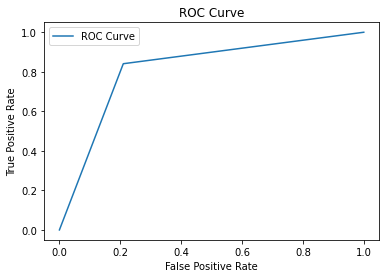

In [133]:
fpr, tpr, _ = roc_curve(y_test, yp)
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

``Feature Importance``

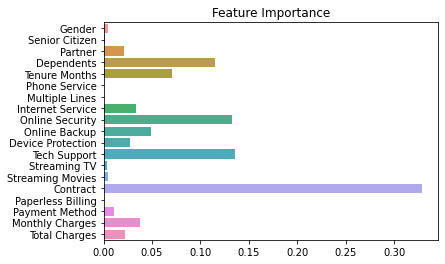

In [134]:
importances = rf.feature_importances_
feature_names = X_train.columns
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importance")
plt.show()


# Step 8: Save Model

In [135]:
joblib.dump(rf, 'optimized_rf_model.pkl')
print("Model saved as 'optimized_rf_model.pkl'")

Model saved as 'optimized_rf_model.pkl'
